## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images'),
 PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [5]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/Seq05VD_f00240.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_06870.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/Seq05VD_f01380.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f04560_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_01920_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_05640_P.png')]

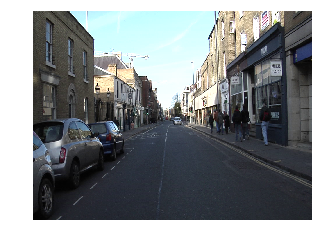

In [7]:
img_f = fnames[1]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [9]:
get_y_fn(img_f) # get_y_fn is a lambda function, and used to get the path to img_f.

PosixPath('/home/jupyter/.fastai/data/camvid/labels/0016E5_06870_P.png')

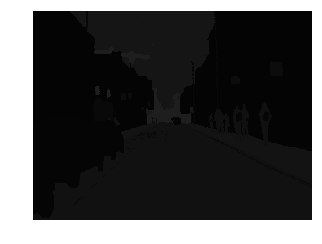

In [10]:
test = open_image(get_y_fn(img_f))
test.show(figsize=(5,5), alpha=1)

```open_mask``` is a function used on the segmented image because it is an array of 32 classes so with open_mask fastai will know what to do....apply colours!

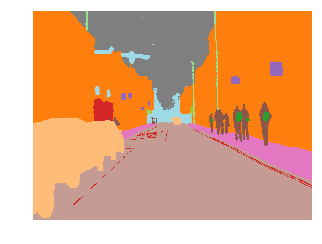

In [11]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [12]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [14]:
len(codes)

32

## Datasets

In [15]:
size = src_size//2
bs=4 # it's such a large dataset, a batch size of 6 is all that could be handled. 

In [16]:
size

array([360, 480])

In [17]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [18]:
data = (src.transform(get_transforms(), size=size, tfm_y=True) # need to transfor the y (labelled data) as well
        .databunch(bs=bs)
        .normalize(imagenet_stats))

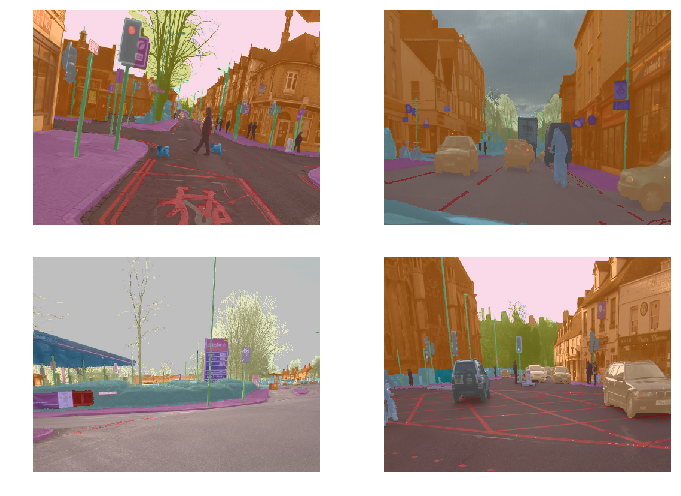

In [19]:
data.show_batch(2, figsize=(10,7))

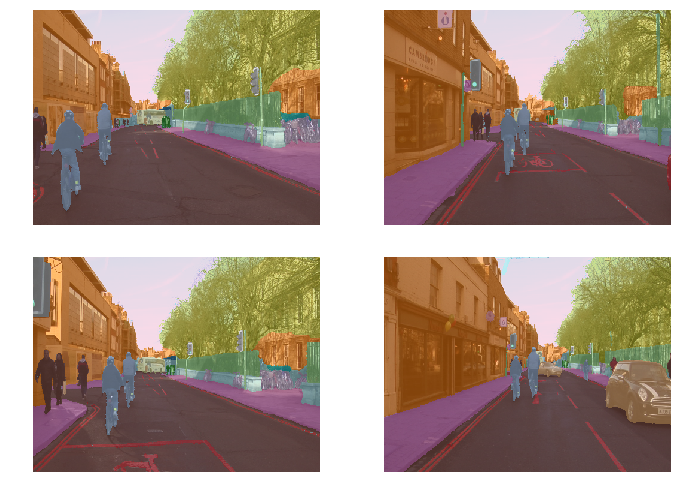

In [20]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [21]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [22]:
metrics=acc_camvid
# metrics=accuracy

In [23]:
wd=1e-2

In [25]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


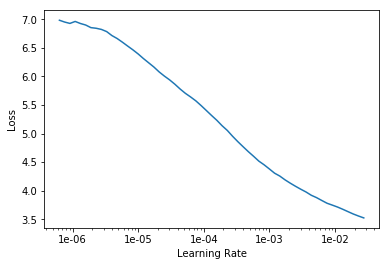

In [26]:
lr_find(learn)
learn.recorder.plot()

In [24]:
lr=3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

In [ ]:
learn.save('stage-1')

In [ ]:
learn.load('stage-1');

In [ ]:
learn.show_results(rows=3, figsize=(8,9))

In [ ]:
learn.unfreeze()

In [27]:
lrs = slice(lr/400,lr/4)

In [ ]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

In [ ]:
learn.save('stage-2');

In [ ]:
learn.recorder.plot()

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`. I've had to decrease the batch size to 1. Segmentation using a lot of GPU

In [25]:
size = src_size
bs=1

In [26]:
src_size

array([720, 960])

In [27]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [28]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [32]:
learn.load('stage-2');

In [ ]:
torch.cuda.empty_cache()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


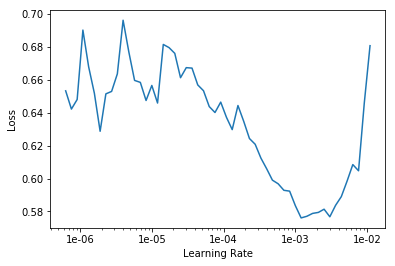

In [33]:
lr_find(learn)
learn.recorder.plot()

In [33]:
lr=1e-3

In [34]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.394084,0.362035,0.897772
2,0.418979,0.344696,0.910860
3,0.401990,0.362179,0.903130
4,0.399991,0.355532,0.910698
5,0.550978,0.394007,0.884214
6,0.513781,0.409267,0.888305
7,0.500003,0.419786,0.890448
8,0.498409,0.373616,0.903072
9,0.340562,0.304056,0.913106
10,0.315673,0.282968,0.919857


In [35]:
learn.save('stage-1-big')

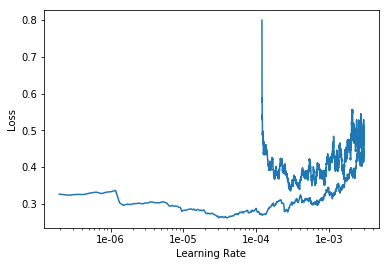

In [36]:
learn.recorder.plot()

In [29]:
learn.load('stage-1-big');

In [30]:
learn.unfreeze()

In [31]:
lrs = slice(1e-6,lr/10)

In [32]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.263685,0.284017,0.920464
2,0.287572,0.277702,0.921314
3,0.271027,0.292158,0.918483
4,0.251047,0.278036,0.922682
5,0.245031,0.284392,0.922434
6,0.250510,0.270526,0.925704
7,0.211882,0.262912,0.928210
8,0.222064,0.282493,0.923033
9,0.221042,0.276389,0.925101
10,0.209184,0.268835,0.926704


In [33]:
learn.save('stage-2-big')

In [34]:
learn.load('stage-2-big');

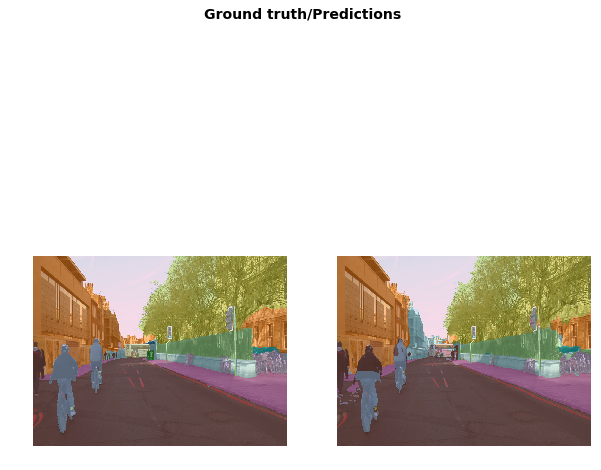

In [36]:
learn.show_results(rows=1, figsize=(10,10))

## fin